In [392]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rd
from numpy.linalg import norm

In [393]:

# Load the data file
mat= scipy.io.loadmat('ex4data1.mat')


In [394]:

def choice (n):
   # Generate one  random numbers
    random_number1 = rd.randint(0, n)
    random_number2 = random_number1+20
    return random_number1,random_number2


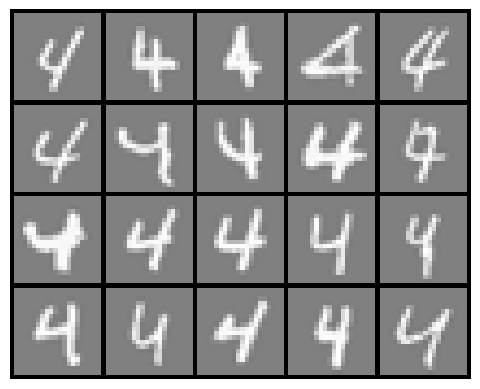

In [395]:

def display_data(X, example_width=None):
    # Set example_width automatically if not passed in
    if example_width is None:
        example_width = int(np.round(np.sqrt(X.shape[1])))

    # Compute rows, cols
    m, n = X.shape
    example_height = n // example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = -np.ones((pad + display_rows * (example_height + pad),
                              pad + display_cols * (example_width + pad)))

    # Copy each example into a patch on the display array
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            # Copy the patch
            # Get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex, :]))
            display_array[pad + j * (example_height + pad) + np.arange(example_height),
                          pad + i * (example_width + pad) + np.arange(example_width)[:, np.newaxis]] = \
                          X[curr_ex, :].reshape(example_height, example_width) / max_val
            curr_ex += 1
        if curr_ex >= m:
            break

    # Display Image
    plt.imshow(display_array, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')
    plt.show()

a,b=choice(5000)
display_data(mat['X'][a:b])



In [396]:

m,n=mat["X"].shape

In [397]:

base_array2= np.array([1, 2, 3, 4, 5, 6, 7, 8, 9,10])

# Create the matrix by tiling the base array along columns (axis=1)
Y= np.tile(base_array2, (5000, 1)).T

In [398]:

#converting the excepted out put Yto the form that model outputes 
for i in range (5000):
    Y[:,i]=(Y[:,i]==mat["y"][i]).astype(int)

In [399]:
Y.shape

(10, 5000)

In [400]:
Y[:,0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [401]:
Y.shape

(10, 5000)

In [402]:

# Sigmoid function to model probability
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [403]:

#Cost function to calculate the error in the prediction
def Costfunction(h, y):
    return -(1/m) * np.sum((y) * np.log(h) + (1 - (y)) * np.log(1 -h))

In [404]:

#RegCost function to calculate the Regularized error in the prediction
def RegCostfunction(h, y,lm,theta1,theta2):
     # Clip h between epsilon and 1-epsilon
    return -(1/m) * np.sum((y) * np.log(h) + (1 - (y)) * np.log(1 - h))+(lm/(2*m))*(np.sum(np.square(theta1[1:,: ]))+np.sum(np.square(theta2[:,1: ])))

In [405]:

#Forward propagation computes the activation of each layer and provides the correct answer based on the switch 
def forward_propagation(input,theta1,theta2,switch_):
    m=input.shape[0]                                  
    a1=np.column_stack((np.ones(m),input))
    z2=a1.dot(theta1)
    a2=np.column_stack((np.ones(m),sigmoid(z2)))
    z3=a2.dot(theta2.T)
    a3=sigmoid(z3)
    # 5000X 401 . 401X25 = 5000X25
      # 5000X25
     # 5000X26
     # 5000X26 . 26x10  = 5000x10
      #5000x10
    if switch_==1:
        return a3.T
    else:
        return a1,z2,a2,z3,a3


In [406]:

#sigmoidGradient computes the gradient of the sigmoid function
def sigmoidGradient(z):
         g=sigmoid(z)
         return g*(1-g)

In [407]:

#randInitializeWeights will initialize the weights randomly to break the symmetry
def randInitializeWeights(input_size, output_size):
    epsilon_init = 0.12  # You can adjust this value based on your preference
    return np.random.rand(output_size, input_size + 1) * 2 * epsilon_init - epsilon_init



In [408]:

#Compute the gradient using forward propagation and backward propagation 
def gradeint(theta1,theta2,input,Y,lm):
    #forward_propagation
    a1,z2,a2,z3,a3 = forward_propagation(input,theta1,theta2,2)
    #backword propagation
    m,n=input.shape
    seta3=a3-(Y.T)# 5000x10
    seta2=(theta2[:,1:].T).dot(seta3.T)*sigmoidGradient(z2.T) #25x10 .10x5000 =25 x 5000  
    grade2=(1/m)*((seta3.T).dot(a2))# 10x5000 . 5000X26 =10X26
    grade2[:,1:]=grade2[:,1:]+(lm/m)*theta2[:,1:]
    grade1=(1/m)*((seta2).dot(a1)) # 25X50000  .5000X401  = 25X401
    grade1[:,1:]=grade1[:,1:]+(lm/m)*theta1.T[:,1:]
    return grade2,grade1

In [409]:

#This function is used to verify that the gradient computed using backpropagation is correct; it is not used during training.
def computeNumericalGradient(input, theta1, theta2, Y, lm,m,epsilon=1e-4):
    num_grad1 = np.zeros_like(theta1)
    num_grad2 = np.zeros_like(theta2)
    for i in range(theta1.shape[0]):
        for j in range(theta1.shape[1]):
            theta1_plus = theta1.copy()
            theta1_minus = theta1.copy()
            theta1_plus[i, j] += epsilon
            theta1_minus[i, j] -= epsilon 

            J_plus = RegCostfunction(forward_propagation(input, theta1_plus, theta2,1),Y,lm,theta1_plus,theta2)
            J_minus = RegCostfunction(forward_propagation(input, theta1_minus, theta2,1),Y,lm,theta1_minus,theta2)

            num_grad1[i, j] = (J_plus - J_minus) / (2 * epsilon)

    for i in range(theta2.shape[0]):
        for j in range(theta2.shape[1]):
            theta2_plus = theta2.copy()
            theta2_minus = theta2.copy()

            theta2_plus[i, j] += epsilon
            theta2_minus[i, j] -= epsilon

            J_plus = RegCostfunction(forward_propagation(input, theta1, theta2_plus,1),Y,lm,theta1,theta2_plus)
            J_minus = RegCostfunction(forward_propagation(input, theta1, theta2_minus,1),Y,lm,theta1,theta2_minus)

            num_grad2[i, j] = (J_plus - J_minus) / (2 * epsilon)

    return num_grad1, num_grad2


num_grad1, num_grad2 = computeNumericalGradient(mat["X"],theta1,theta2,Y,1,m)


grade1,grade2=gradeint(theta1,theta2,mat["X"],Y,lm)

roll_num_grad1= num_grad1.reshape(-1, 1)


roll_grad1=(grade1.T).reshape(-1,1)


roll_num_grad2= num_grad2.reshape(-1, 1)
roll_grad2=(grade2).reshape(-1,1)

h=np.concatenate((roll_num_grad1,roll_num_grad2))
t=np.concatenate((roll_grad1,roll_grad2))

norm(h-t)/norm(h+t)#9.421474999634163e-11

In [410]:

#This function is used to train the model and find the optimal value of the weights (theat)
def training(theta1,theta2,input,Y,num_iterations,alpha,lm,cost_history):
    for i in range(num_iterations): 
        grade2,grade1= gradeint(theta1,theta2,input,Y,lm)
        theta1=theta1-alpha*grade1.T
        theta2=theta2-alpha*grade2
        cost_history[i, 0] = RegCostfunction(forward_propagation(input, theta1, theta2,1),Y,lm,theta1,theta2)
    return theta1,theta2,cost_history

In [411]:

#Initializing required parameters.
lm=1
alpha =.1
num_iterations = 1000
cost_history = np.zeros((num_iterations, 1))
iteration_history = np.arange(num_iterations).reshape(-1, 1)

In [412]:
#Initializing  theta's
theta1=randInitializeWeights(24, 401)
theta2=randInitializeWeights(25,10)

In [413]:

#model training
thataf1,thetaf2,cost_histaory=training(theta1,theta2,mat["X"],Y,num_iterations,alpha,lm,cost_history)

In [415]:
print("the final error of the model = ",cost_histaory[-1,0])

the final error of the model =  1.2286142788715848


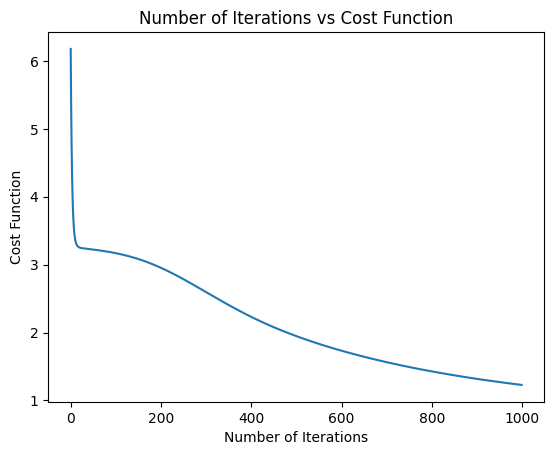

In [416]:

# Plot cost function over iterations
plt.figure()
plt.plot(iteration_history, cost_history)
plt.xlabel('Number of Iterations')
plt.ylabel('Cost Function')
plt.title('Number of Iterations vs Cost Function')
plt.show()

In [417]:

prediction=forward_propagation(mat["X"],thataf1,thetaf2,1)

In [418]:

prediction = (prediction >= 0.5).astype(int)

In [419]:

# Compare the matrices element-wise and create a boolean matrix indicating differences
differences = prediction != Y

# Calculate the percentage of differences
percentage_wrong = (np.count_nonzero(differences) / differences.size) * 100
percentage_correct = 100 - percentage_wrong

print("Percentage of elements that are correct: {:.2f}%".format(percentage_correct))

Percentage of elements that are correct: 96.06%
